In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

sys.path.append('../')

from src.emotion.analysis.data_preprocessing import (
    DataPreprocessor,
    LinearInterpolator,
    RollingAverageSmoother,
)

from src.emotion.analysis.feature_generator import FeatureGenerator, VADGenerator

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
emotions = ["Angry", "Disgust", "Happy", "Sad", "Surprise", "Fear", "Neutral"]
vad = ["Valence", "Arousal", "Dominance"]

In [3]:
folder = '/home/moritz/Workspace/masterthesis/data/identities/'
df = pd.read_csv(folder + 'team_20/2023-01-10/team_20_2023-01-10.csv')

In [4]:
# Create a dictionary with the given data
mapping = {
    'Angry': [-0.43, 0.67, 0.34],
    'Happy': [0.76, 0.48, 0.35],
    'Surprise': [0.4, 0.67, -0.13],
    'Disgust': [-0.6, 0.35, 0.11],
    'Fear': [-0.64, 0.6, -0.43],
    'Sad': [-0.63, 0.27, -0.33],
    'Neutral': [0.0, 0.0, 0.0]
}


features_pipeline = [VADGenerator(mapping=mapping)]

feature_generator = FeatureGenerator(features_pipeline)
feature_df = feature_generator.generate_features(df)

feature_df.head()

,Frame,ClassID,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,GazeDetections,Brightness,Valence,Arousal,Dominance
0,0,person_id1,0.888322,963.261841,609.813171,0.006095,0.025079,0.089205,0.181192,0.000575,0.005860,0.691994,['person_id2'],139.656602,-0.067544,0.108503,-0.026335
1,0,person_id4,0.829193,776.653320,232.195343,0.039845,0.044471,0.192252,0.035983,0.034824,0.106690,0.545934,['person_id1'],139.656602,0.025274,0.231604,0.023449
2,0,person_id2,0.716269,262.923309,278.470093,0.000042,0.000052,0.986540,0.000961,0.006420,0.000264,0.005722,[],139.656602,0.751515,0.478304,0.344044
3,5,person_id1,0.888996,975.549072,616.918701,0.003787,0.013471,0.651937,0.103395,0.000332,0.001300,0.225778,['person_id2'],140.160465,0.419923,0.349101,0.196225
4,5,person_id4,0.801439,766.165710,233.864716,0.109647,0.280549,0.016583,0.430486,0.025592,0.058128,0.079016,['person_id1'],140.160465,-0.501045,0.347870,-0.096438


In [5]:
preprocessing_pipeline = [
    LinearInterpolator(),
    RollingAverageSmoother(
        window_size=1500,
        cols=[*emotions, *vad],
    ),
]

preprocessor = DataPreprocessor(preprocessing_pipeline)
pre_df = preprocessor.preprocess_data(feature_df)

pre_df.head()

,Frame,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,Brightness,Valence,Arousal,Dominance,ClassID
0,0,0.888322,963.261841,609.813171,0.023968,0.013228,0.175740,0.045136,0.090784,0.009917,0.641228,139.656602,0.116850,0.184005,0.040152,person_id1
1,5,0.888996,975.549072,616.918701,0.023943,0.013213,0.175525,0.045087,0.090701,0.009904,0.641627,140.160465,0.116713,0.183804,0.040099,person_id1
2,10,0.858353,1011.880005,632.941284,0.023919,0.013196,0.175294,0.045030,0.090648,0.009891,0.642022,140.381493,0.116581,0.183612,0.040040,person_id1
3,15,0.839160,1029.355957,625.232300,0.023893,0.013179,0.175063,0.044977,0.090551,0.009878,0.642460,141.136083,0.116430,0.183390,0.039984,person_id1
4,20,0.844532,1031.143921,624.424683,0.023874,0.013237,0.174844,0.045013,0.090815,0.009875,0.642342,141.495661,0.116321,0.183478,0.039862,person_id1


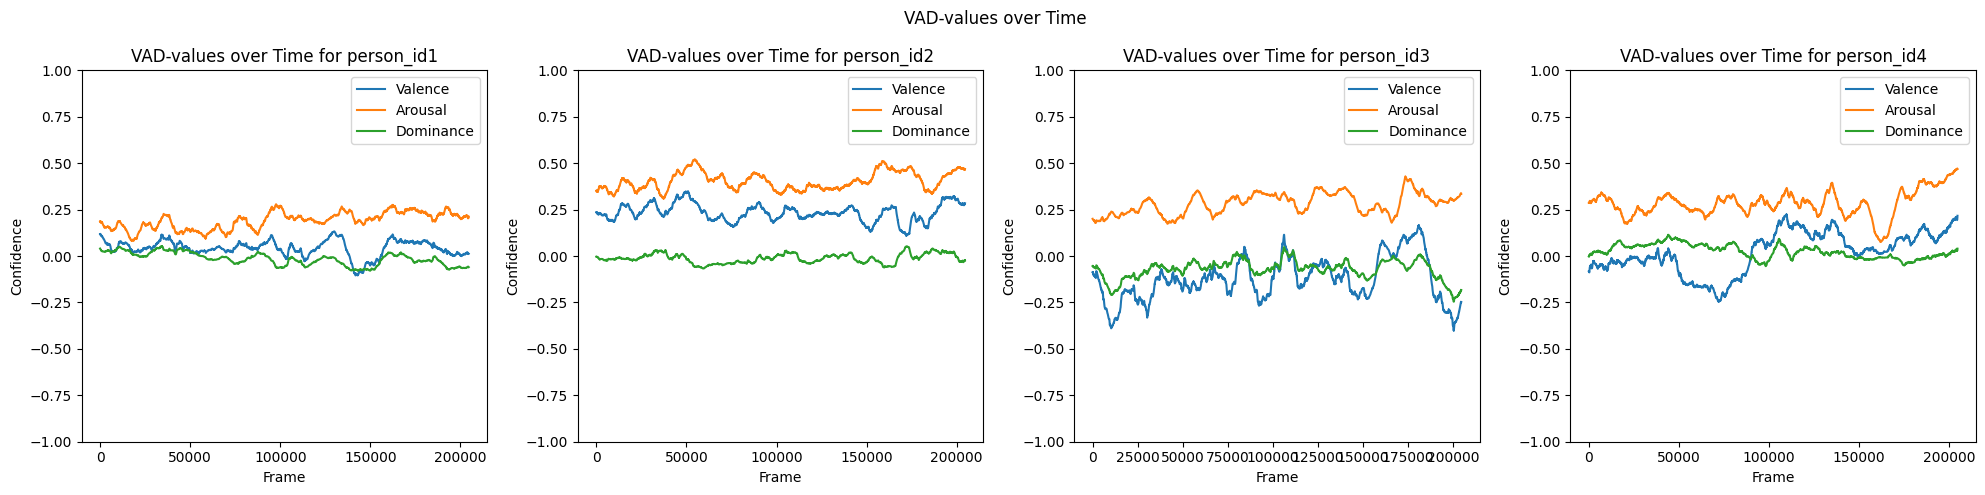

In [6]:
grouped = pre_df.groupby("ClassID")

fig = plt.figure(figsize=(20, 5), tight_layout=True)
fig.suptitle("VAD-values over Time")

for i, (person_id, group) in enumerate(grouped):
    emotions_rolling = group[["Frame", *vad]]

    ax = fig.add_subplot(1, 4, i + 1)
    emotions_rolling.plot(
        x="Frame",
        y=vad,
        ax=ax,
    )

    ax.set_title(f"VAD-values over Time for {person_id}")
    ax.set_xlabel("Frame")
    ax.set_ylabel("Confidence")
    ax.set_ylim(-1, 1)

plt.show()

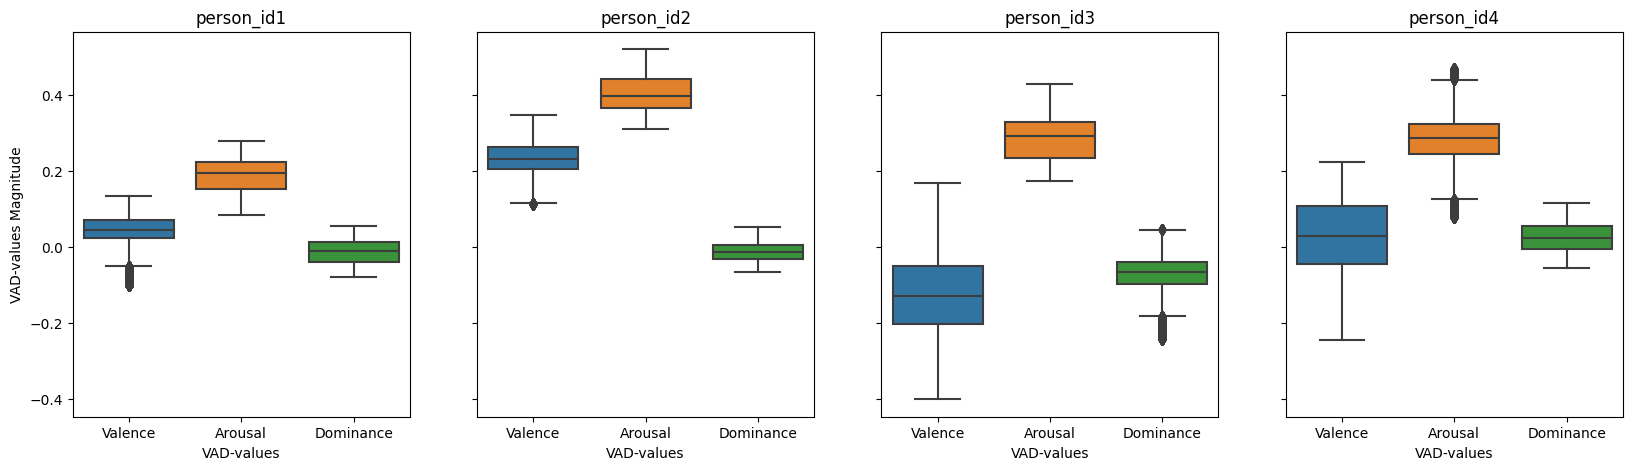

In [7]:
# Set the figure size
fig, axes = plt.subplots(1, len(pre_df['ClassID'].unique()), figsize=(20, 5), sharey=True)

# Loop over each ClassID and plot a boxplot for each emotion
for i, cid in enumerate(pre_df['ClassID'].unique()):
    # Subset the data for the current ClassID
    subset = pre_df[pre_df['ClassID'] == cid][vad]
    # Plot the boxplot for each emotion on a separate subplot
    sns.boxplot(data=subset, ax=axes[i])
    axes[i].set_title(f'{cid}')
    axes[i].set_xlabel('VAD-values')

# Set the y-axis label on the first subplot only
axes[0].set_ylabel('VAD-values Magnitude')

# Show the plot
plt.show()

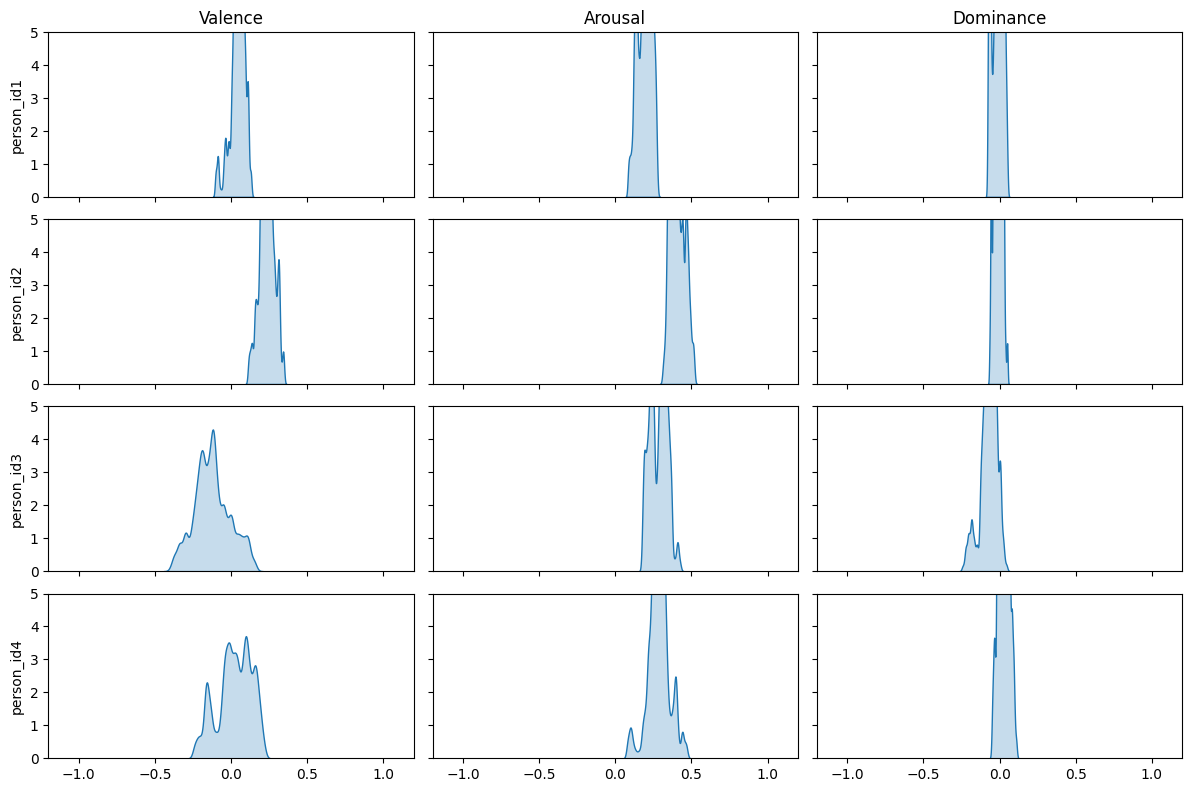

In [8]:
# Group the data by ClassID and emotion columns
grouped = pre_df.groupby(['ClassID', *vad]).size().reset_index(name='count')

# Define the size of the figure and the number of rows and columns
fig, axes = plt.subplots(nrows=len(grouped['ClassID'].unique()), ncols=len(vad), figsize=(12, 8), sharex=True, sharey=True)

# Set the x and y axis limits
xlim = (-1.2, 1.2)
ylim = (0, 5)

# Loop over each ClassID and emotion, and plot a distribution plot
for i, cid in enumerate(grouped['ClassID'].unique()):
    for j, e in enumerate(vad):
        sns.kdeplot(data=grouped[(grouped['ClassID'] == cid)], x=e, ax=axes[i, j], fill=True)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel(f'{cid}')
        if i == 0:
            axes[i, j].set_title(f'{e}')
        axes[i, j].set_xlim(xlim)
        axes[i, j].set_ylim(ylim)

# Adjust the spacing between subplots
fig.tight_layout(pad=1)
plt.show()

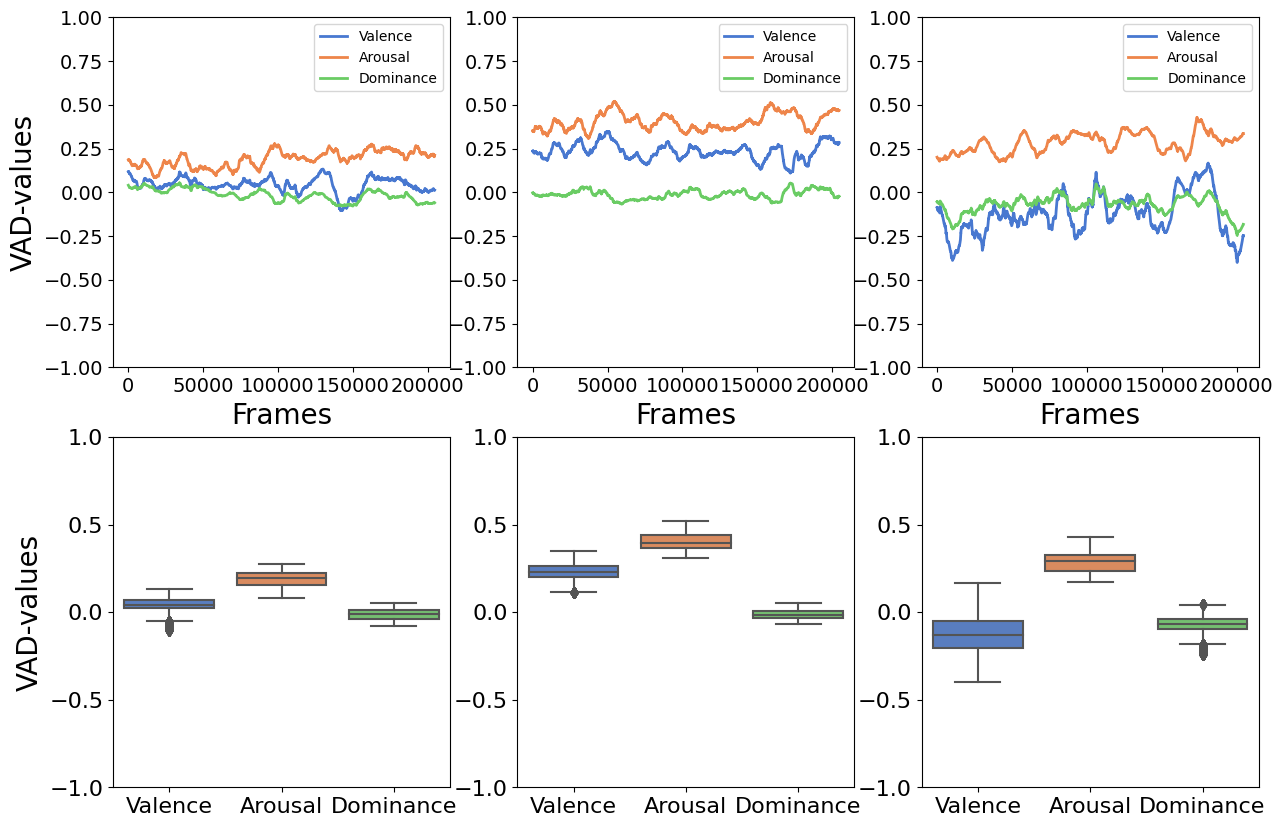

In [10]:
grouped = pre_df.groupby("ClassID")
class_ids = pre_df['ClassID'].unique()

fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(2, len(class_ids), height_ratios=[1, 1])

# Create a custom color palette
palette = sns.color_palette("muted", n_colors=len(vad))

# Set font sizes
title_font_size = 16
label_font_size = 20
tick_font_size = 14
line_width = 2

for i, cid in enumerate(class_ids):
    if i == 3:
        break
    group = grouped.get_group(cid)
    emotions_rolling = group[["Frame", *vad]]

    # VAD-values over time plot (upper half)
    ax1 = plt.subplot(gs[0, i])
    emotions_rolling.plot(x="Frame", y=vad, ax=ax1, color=palette, linewidth=line_width)

    ax1.set_xlabel("Frames", fontsize=label_font_size)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    if i == 0:
        ax1.set_ylabel("VAD-values", fontsize=label_font_size)
    ax1.set_ylim(-1, 1)

    # VAD-values magnitude plot (lower half)
    ax2 = plt.subplot(gs[1, i])
    subset = pre_df[pre_df['ClassID'] == cid][vad]
    sns.boxplot(data=subset, ax=ax2, palette=palette)

    ax2.tick_params(axis='both', which='major', labelsize=16)
    if i == 0:
        ax2.set_ylabel("VAD-values", fontsize=label_font_size)
    ax2.set_ylim(-1, 1)
    #ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results"
image = path + "/vad.pdf"
plt.savefig(image, bbox_inches='tight', dpi=300)
